# Section 1: Pseudocode for dentist algorithm

```
# Main dentist algorithm loop
for step in range(total_steps):
    # Propose new parameter values based on normal distribution
    proposed_parameters = sample_normal_distribution(parameters_vector, proposal_width)
    # Compute the likelihood of the proposed parameters
    proposed_likelihood = compute_likelihood(proposed_parameters)
    # Calculate the bias based on user-selected confidence interval
    bias = compute_bias(confidence_level, adjust_width_interval)
    
    # Check if the proposed point "dents" the likelihood surface
    if proposed_likelihood < -LnLik + bias:
        # Accept the proposed parameters
        parameters_vector = proposed_parameters
    
    # Check if it's time to adjust the proposal width
    if step % adjust_width_interval == 0:
        # Calculate the denting success rate
        dent_success_rate = calculate_dent_success_rate(adjust_width_interval)
    
    # Adjust proposal width based on the success rate
    if dent_success_rate > max_dent_attempts:
        proposal_width *= 1.5 # Increase proposal width
    elif dent_success_rate < min_dent_attempts:
        proposal_width *= 0.8 # Decrease proposal width
```

# Section 2: Examination of high dimensional model preformance

In [1]:
# ignore this code, this is because my R environments for jupyter differ from rstudio
.libPaths(
  c(.libPaths(), 
    "/home/jboyko/R/x86_64-pc-linux-gnu-library/4.1",
    "/usr/local/lib/R/site-library", 
    "/usr/lib/R/site-library",
    "/usr/lib/R/library")
)


Needed libraries

In [2]:
setwd("~/dentist-paper/")
library(corHMM)
library(phytools)
library(dentist)

Loading required package: ape

Loading required package: nloptr

Loading required package: GenSA

Loading required package: maps

Registered S3 methods overwritten by 'dentist':
  method        from  
  plot.dentist  corHMM
  print.dentist corHMM



The dataset comes from unpublished empirical work and thus names of species and traits are removed. This dataset is not curated to produce a desired result, but is the most recent example I have of this phenomenon.


In [4]:
# Load data
dat <- read.csv("trait_data.csv")

# Load tree data
tree <- read.tree("tree.tre")

# fit the model
# model_fit <- corHMM(tree, dat, 1)
# save(model_fit, file = "saves/complex-corhmm-model.rsave")
load("saves/complex-corhmm-model.rsave")

Fit dentist to this data, we will examine more closely the difficulties in estimating parameters. As we'll see plots from dentist illustrate that this dataset is odd, but it fails to capture the extent of the problems. 

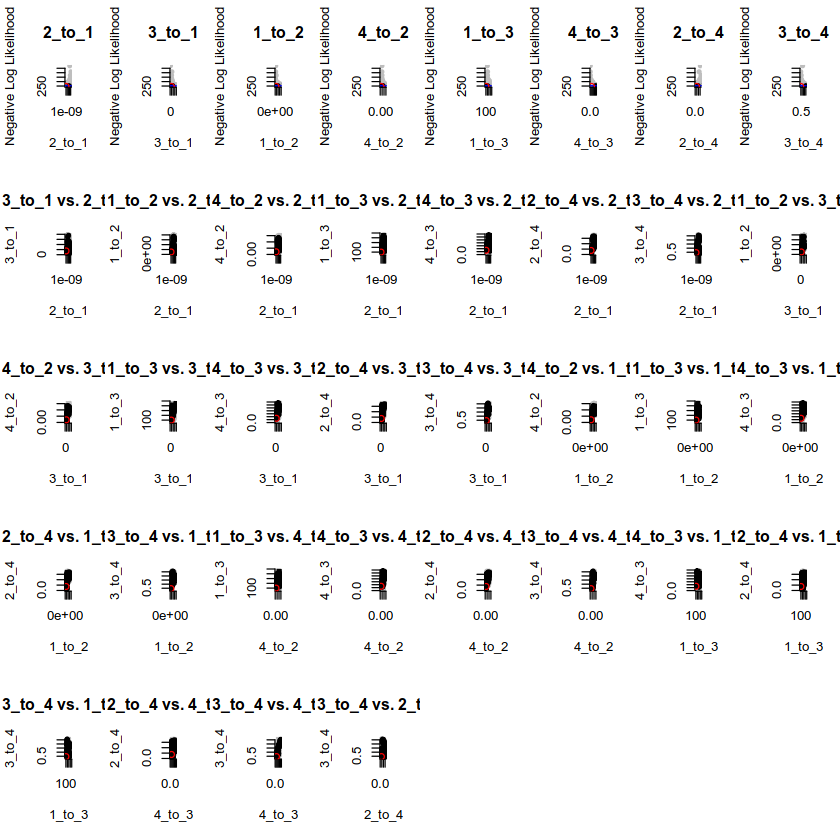

In [5]:
fn_corHMM <- function(par, phy, data){
  corhmm_fit <- corHMM(phy = phy, data = data, rate.cat = 1, p = par)
  loglik <- corhmm_fit$loglik
  neg_loglik <- -loglik
  return(neg_loglik)
}

p <- sapply(1:max(model_fit$index.mat, na.rm = TRUE), function(x) 
  na.omit(c(model_fit$solution))[na.omit(c(model_fit$index.mat) == x)][1])

model_fit$index.mat[is.na(model_fit$index.mat)] <- 0
par_names <- c()
for(i in 1:8){
  index <- which(model_fit$index.mat == i, arr.ind = TRUE)
  from <- rownames(model_fit$index.mat)[index[1]]
  to <- colnames(model_fit$index.mat)[index[2]]
  par_names[i] <- paste0(from, "_to_", to)
}
par_names <- gsub("\\(", "", par_names)
par_names <- gsub("\\)", "", par_names)
names(p) <- par_names

# dent_res <- dent_walk(par=p, fn=fn_corHMM, best_neglnL=-model_fit$loglik, nsteps=1000, print_freq=1e10, phy = tree, data = dat)
# dent_res <- dent_walk(par=p, fn=fn_corHMM, best_neglnL=-model_fit$loglik, nsteps=1000, print_freq=1e10, phy = tree, data = dat)
# save(dent_res, file = "saves/dent_res_complex.rsave")
load("saves/dent_res_complex.rsave")
plot(dent_res)

It's hard to see all the plots on jupyter-notebook, so lets examine just a few examples in depth. 

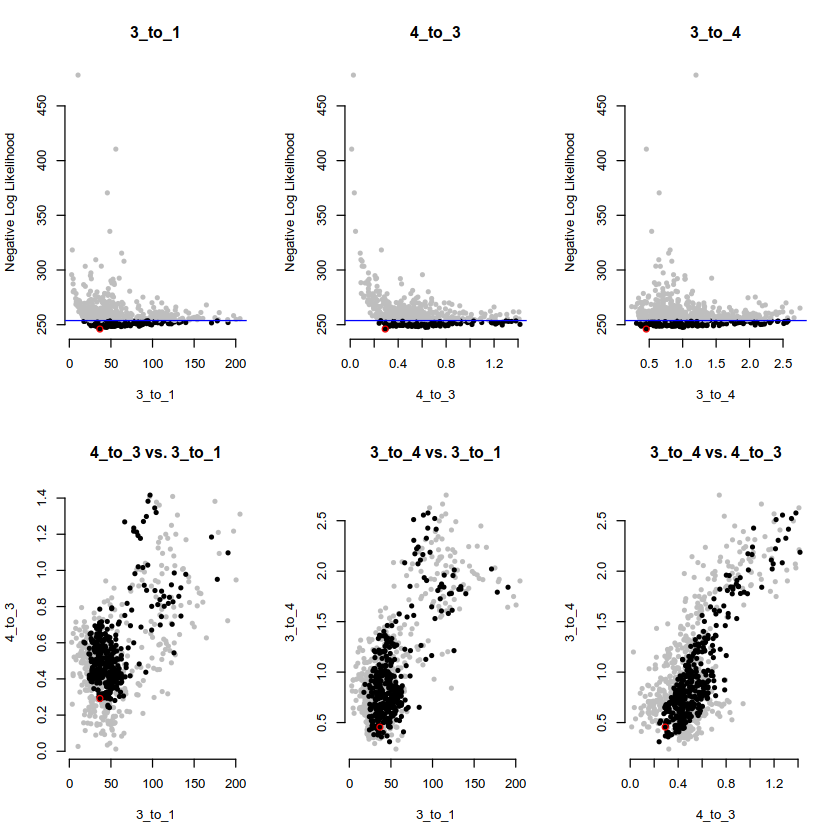

In [6]:
tmp <- dent_res
tmp$results <- tmp$results[,-c(2,4,5,6,8)]
dentist:::plot.dentist(tmp)

In this case we are starting to see evidence of a ridge in this highly dimensional parameter space, particularly for the very high estimated trasntion rates (3 to 1), but the full extent of this issue isn't appreciated in dentist.

In [10]:
print(model_fit$loglik)
print(model_fit$solution)

[1] -246.0235
             (1,R1)       (2,R1)     (3,R1)    (4,R1)
(1,R1)           NA 1.001032e-09 99.9945195        NA
(2,R1)  0.000000001           NA         NA 0.1478496
(3,R1) 36.759159193           NA         NA 0.4551907
(4,R1)           NA 2.079956e-02  0.2919256        NA


Here is our MLE for the discrete character model. We can that element [1,3] (the transtion from 1,R1 to 3,R1) is estimated to be orders of magnitude faster than most other transitions. What I will do is drop those very high transitions and refit the model.

In [13]:
test_mat <- getStateMat4Dat(model_fit$data)
rate_mat_a <- dropStateMatPars(test_mat$rate.mat, c(2,5))
print(rate_mat_a)

    (1) (2) (3) (4)
(1)  NA   2  NA  NA
(2)   1  NA  NA   5
(3)  NA  NA  NA   6
(4)  NA   3   4  NA


This is our index matrix for the model to know which parameters are allowed to be estimated. If a parameter is missing it can be thought to be set to 0 (roughly).

In [14]:
tmp_a <- corHMM(tree, model_fit$data, 1, rate_mat_a)

State distribution in data:
States:	1	2	3	4	
Counts:	25	16	68	106	
Beginning thorough optimization search -- performing 0 random restarts 
Finished. Inferring ancestral states using marginal reconstruction. 


In [16]:
print(tmp_a$loglik)
print(tmp_a$solution)

[1] -245.8233
       (1,R1)      (2,R1)     (3,R1)    (4,R1)
(1,R1)     NA 64.03846089         NA        NA
(2,R1)    100          NA         NA 0.4927100
(3,R1)     NA          NA         NA 0.1303647
(4,R1)     NA  0.07511066 0.08302883        NA


What we see here is a model that is within a couple likelihood units, has fewer estimated parameters, and (most importantly for my point here) has parameter estimates that are wildly different from the purported MLE! Specifically, if you look at element [1,2] and [2,1] those transition rates went from estimated at nearly 0 to estimated near the upper bound. 

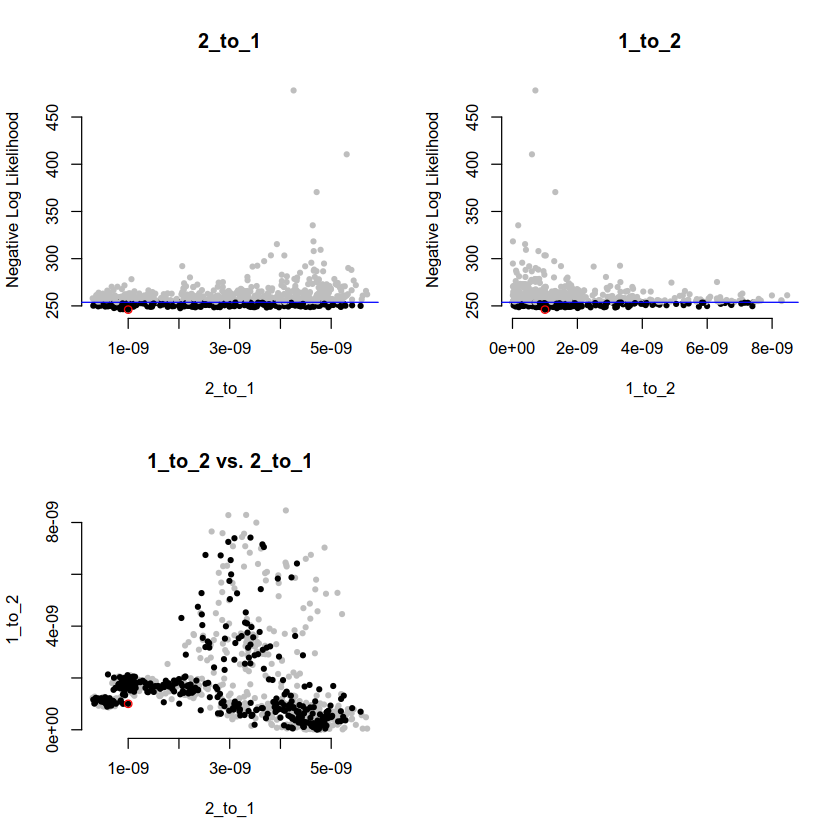

In [17]:
tmp <- dent_res
tmp$results <- tmp$results[,-c(3,5:9)]
dentist:::plot.dentist(tmp)


However, dentist isn't able to capture this uncertainty, likely because the space has to cross a suboptimal valley in likelihood space. Dentist's estimates suggest things should be near 0. 

In conclusion, the dentist plots indicate that there are concerns with this dataset through ridges appearing. However, it fails to capture the full extent of the parameter uncertainty when the local optima are very far apart in the high dimensional parameter space. Perhaps with more sampling and larger jumps per sample we could find these issues. Nonetheless, for low dimensional models dentist will continue to work well and we will look to improve the software for problems such as this. It may mean custom designing sampling algorithms for comparative models.